# Mental Health Chatbot Development Notebook

In [1]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading and Viewing the Dataset

- Reads the dataset from a CSV file (`mental_health_training.csv`).
- Displays a sample of 5 random rows to get an overview of the data.


In [2]:

# Load dataset
import tabulate

df = pd.read_csv("../Data/mental_health_training.csv")
print("Dataset Overview:")
df.sample(n=5, random_state=42)

Dataset Overview:


,question,answer,pattern,tag
322,can you prevent mental health problems?,We can all suffer from mental health challenge...,can you prevent mental health problems?,fact-25
116,not really,Let's discuss further why you're feeling this ...,not really,casual
113,yeah,Let's discuss further why you're feeling this ...,yeah,casual
42,what should i call you?,"I'm Pandora, your Personal Therapeutic AI Assi...",what should i call you?,about
126,just shut up,Talking about something really helps. If you'r...,just shut up,not-talking


# Creating Intents Dictionary

- Converts the dataset into an intents JSON format.
- Splits questions into multiple patterns.
- Organizes tags, patterns, and responses into a structured dictionary.
- Saves the formatted intents into a JSON file for future use.


In [3]:
# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    question = df['question'][ind]
    if pd.notna(question):
        questions = question.lower().replace('?', '.').split('.')
    else:
        questions = []
    
    patterns = [q.strip() for q in questions if q.strip()]
    pattern = df['pattern'][ind]
    if pd.notna(pattern):
        patterns.append(pattern.lower().strip())
    
    responses = df['answer'][ind]
    tag = df['tag'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)
print(" Some Intents from the dataset:")
print(dict_["intents"][:2])

with open("../Data/intents.json", "w") as f:
    json.dump(dict_, f)

 Some Intents from the dataset:
[{'tags': ['greeting'], 'patterns': ['hi', 'hi'], 'responses': ['Hello there. Tell me how are you feeling today?']}, {'tags': ['greeting'], 'patterns': ['hey', 'hey'], 'responses': ['Hello there. Tell me how are you feeling today?']}]


In [5]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Define the list of words
words = df['question'].str.lower().str.split().explode()

# Remove stopwords from the list of words
words = words[~words.isin(stop_words)]

print(words)

0               hi
1              hey
2           anyone
3           anyone
3           there?
          ...     
339        sadness
339    depression?
340     difference
340        sadness
340     depression
Name: question, Length: 776, dtype: object


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Handle missing values

In [6]:
df.dropna(inplace=True)


- Remove duplicates

In [7]:
df.drop_duplicates(inplace=True)


# Loading BERT Tokenizer and Model

- Loads the `bert-base-uncased` tokenizer and model from Hugging Face's Transformers library.
- Defines a function to extract sentence embeddings using BERT.
- Tokenizes words in the dataset and applies lemmatization.
- Stores words and classes in pickle files for later use.


In [8]:
import torch
from transformers import AutoTokenizer, AutoModel
from nltk.stem import WordNetLemmatizer
import pickle

# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']
lemmatizer = WordNetLemmatizer()

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('../Data/words.pkl', 'wb'))
pickle.dump(classes, open('../Data/classes.pkl', 'wb'))

# Preparing Training Data

- Uses `LabelBinarizer` to convert text labels (tags) into one-hot encoded numerical format.
- Generates sentence embeddings using BERT.
- Prepares training data by pairing embeddings with their corresponding labels.


In [9]:
# Prepare training data
from sklearn.naive_bayes import LabelBinarizer



label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

training = []
for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

# Splitting Training and Validation Data

- Splits the dataset into an 80% training and 20% validation set.
- Defines an exponential learning rate decay schedule for the optimizer.


In [10]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Splitting data into training and validation sets (80% training, 20% validation)
split_idx = int(0.8 * len(train_x))
X_train, X_val = train_x[:split_idx], train_x[split_idx:]
y_train, y_val = train_y[:split_idx], train_y[split_idx:]

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

In [11]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

# Define model architecture with regularization (NO BATCH NORMALIZATION)
model = Sequential([
    Dense(128, input_shape=(len(train_x[1]),), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    Dense(len(train_y[0]), activation='softmax')
])

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Compile with Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

# Model summary
model.summary()


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 79)             │         5,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,823 (436.81 KB)

 Trainable params: 111,823 (436.81 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = model.fit(np.array(train_x), np.array(train_y), 
                 epochs=50, batch_size=12, 
                 validation_split=0.2, 
                 callbacks=[early_stop], 
                 verbose=1)

model.save('../model/conversationalchatbotmodel.h5', hist)
print('Training Complete')

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0210 - loss: 7.1102 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1583 - val_loss: 6.0523
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.3085 - Recall: 9.0648e-04 - accuracy: 0.1325 - loss: 5.7747 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2086 - val_loss: 5.0867
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.1666 - Recall: 0.0021 - accuracy: 0.1641 - loss: 4.9866 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3094 - val_loss: 4.4374
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.9270 - Recall: 0.0347 - accuracy: 0.2518 - loss: 4.3022 - val_Precision: 1.0000 - val_Recall: 0.0216 - val_accuracy: 0.3453 - val_loss: 4.0051
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.8742 - Recall: 0.0538 - accuracy: 0.3158 - loss: 3.9693 - val_Prec

Training Complete


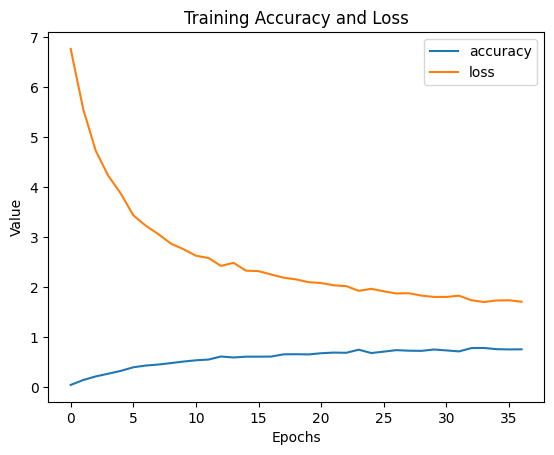

In [13]:

# Plot training accuracy and loss over epochs
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

# Loading the Model for Chatbot Prediction

- Loads the trained chatbot model.
- Defines a function `predict_class()` to classify user input.
- Implements a chatbot loop that takes user input, predicts intent, and generates a response.


In [ ]:
# Load the model for prediction
model = load_model('../model/conversationalchatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("CHAT_BOT IS LIVE NOW....")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

CHAT_BOT IS LIVE NOW....
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Bot: Hello there. Tell me how are you feeling today?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Bot: That's geat to hear. I'm glad you're feeling this way.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Bot: I'm Pandora, your Personal Therapeutic AI Assistant. How are you feeling today
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Bot: I was created by Charite😌
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Bot: Duh I live in your computer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Bot: Sure. I'll try my best to answer you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Bot: For a diagnosis of depression, a person needs to have experienced low mood or loss of interest or pleasure in life for at least 2 weeks. Also, they will have experienced the following symptoms: feelings of sadness, hopelessness, or irritability nearly every day.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Bot: Let's discuss further why you're feeling this way.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Bot: H

# Evaluating Model Performance

- Uses classification metrics (`accuracy_score`, `f1_score`, and `classification_report`).
- Compares predicted vs. actual labels.
- Displays a detailed classification report for model evaluation.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Evaluate the model
y_pred = model.predict(train_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(train_y, axis=1)

# Calculate and print metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.9363
F1 Score: 0.9262
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         4
           4       0.89      1.00      0.94        24
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        16
           8       0.80      0.80      0.80        10
           9       1.00      1.00      1.00        12
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         4
          15       0.00      0.00      

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### **Performance Metrics Overview**  

#### **Accuracy: 0.9363**  
The model correctly predicted the class for **93.63%** of the samples in the training set. While this is a strong performance, it indicates that some misclassifications occurred.  

#### **F1 Score: 0.9262**  
An F1 score of **0.9262** reflects a good balance between precision and recall, meaning the model makes accurate predictions while minimizing false positives and false negatives.  

### **Detailed Classification Report**  

- **Precision** (True Positives / Predicted Positives)  
  - Measures how many of the predicted positive cases were actually correct.  
  - A high precision score suggests the model makes few false positive predictions.  

- **Recall** (True Positives / Actual Positives)  
  - Indicates how well the model identifies all true instances of a class.  
  - A good recall score means the model captures most relevant cases with minimal false negatives.  

- **F1 Score** (Harmonic Mean of Precision & Recall)  
  - Ensures a balanced evaluation by considering both precision and recall.  
  - An F1 score of **0.9262** suggests the model maintains strong predictive performance across all classes.  

- **Support** (Total Samples per Class)  
  - Indicates the number of instances in the dataset for each class.  
  - Helps assess how well the model performs on different class distributions.  

### **Summary of Results**  

- **Overall Performance:** The model demonstrates **strong classification accuracy (93.63%)** and **high F1 score (92.62%)**, indicating effective generalization.  
- **Macro Average:** Evaluates the model’s performance equally across all classes.  
- **Weighted Average:** Accounts for class distribution, ensuring more frequent classes do not dominate the evaluation.  

While the model performs well, some misclassifications exist, suggesting potential areas for improvement, such as hyperparameter tuning, additional data augmentation, or refining feature extraction techniques.
